In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ==============================================================================
# BƯỚC 1: CÀI ĐẶT & IMPORT THƯ VIỆN
# ==============================================================================
!pip install --upgrade scipy scikit-learn pandas
!pip install transformers datasets sacremoses pysrt underthesea \
             sacrebleu unbabel-comet tqdm accelerate evaluate \
             sentencepiece torch "numpy<2.0.0" --quiet

print("Đã cài đặt xong thư viện!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 144.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
import glob
import random
import shutil
import pandas as pd
import pysrt
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
from underthesea import word_tokenize
import evaluate

In [2]:
# ==============================================================================
# BƯỚC 2: CẤU HÌNH HỆ THỐNG & ĐƯỜNG DẪN
# ==============================================================================
MAIN_WORKSPACE = '/content/drive/MyDrive/Colab_Notebooks/ITP'
DICT_PATH = os.path.join(MAIN_WORKSPACE, 'workspace', 'chinese-hanviet-cognates.tsv')
MAIN_DATASET_ROOT = os.path.join(MAIN_WORKSPACE, 'data')

# Nơi lưu dữ liệu đã xử lý để dùng lại sau này
DATA_SPLIT_DIR = os.path.join(MAIN_WORKSPACE, 'data_split')
os.makedirs(DATA_SPLIT_DIR, exist_ok=True)

# Nơi lưu checkpoint và model cuối
OUTPUT_DIR = os.path.join(MAIN_WORKSPACE, 'workspace', "zh-vi-historical-model")
FINAL_MODEL_DIR = os.path.join(MAIN_WORKSPACE, 'workspace', "final_model")

# THAM SỐ ISS (Intelligent Subtitle Segmentation)
ISS_EPSILON = 500  # Sai số cho phép 500ms khi căn chỉnh

# Kiểm tra GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Đã tìm thấy GPU: {torch.cuda.get_device_name(0)}")
    USE_FP16 = True # Dùng GPU thì bật FP16 cho nhanh
else:
    device = torch.device("cpu")
    print("Không tìm thấy GPU, đang chạy trên CPU")
    USE_FP16 = False

Đã tìm thấy GPU: Tesla T4


In [3]:
# ==============================================================================
# BƯỚC 3: HỆ THỐNG ISS (ALIGNMENT) & SBA (AUGMENTATION)
# ==============================================================================

def load_dictionary(file_path):
    print(f"Đang đọc từ điển: {file_path}")
    try:
        df = pd.read_csv(file_path, sep='\t').dropna(subset=['word', 'hanviet'])
        return df['word'].astype(str).tolist(), df['hanviet'].astype(str).tolist()
    except Exception as e:
        print(f"Lỗi đọc từ điển: {e}")
        return [], []

def clean_text(text):
    if not isinstance(text, str): return ""
    return text.replace('\n', ' ').replace('<i>', '').replace('</i>', '').strip()

def align_subtitles_by_time(zh_path, vi_path, epsilon=500):
    try:
        subs_zh = pysrt.open(zh_path, encoding='utf-8')
        subs_vi = pysrt.open(vi_path, encoding='utf-8')
    except Exception as e:
        return [], []

    src_aligned, tgt_aligned = [], []
    vi_idx = 0
    max_vi = len(subs_vi)

    for zh_sub in subs_zh:
        zh_start = zh_sub.start.ordinal
        best_match = None
        min_diff = float('inf')
        temp_idx = vi_idx
        while temp_idx < max_vi:
            vi_sub = subs_vi[temp_idx]
            vi_start = vi_sub.start.ordinal
            diff = abs(zh_start - vi_start)
            if vi_start > zh_sub.end.ordinal + epsilon: break
            if diff <= epsilon:
                if diff < min_diff:
                    min_diff = diff
                    best_match = vi_sub
                    vi_idx = temp_idx
            temp_idx += 1
        if best_match:
            src_aligned.append(clean_text(zh_sub.text))
            tgt_aligned.append(clean_text(best_match.text))
    return src_aligned, tgt_aligned

def sentence_boundary_augmentation(src_list, tgt_list, merge_prob=0.3):
    aug_src, aug_tgt = [], []
    i = 0
    while i < len(src_list):
        if i < len(src_list) - 1 and random.random() < merge_prob:
            s1, s2 = src_list[i], src_list[i+1]
            t1, t2 = tgt_list[i], tgt_list[i+1]
            aug_src.append(s1.rstrip("。，！？…") + " " + s2)
            aug_tgt.append(t1 + " " + t2)
            i += 2
        else:
            aug_src.append(src_list[i])
            aug_tgt.append(tgt_list[i])
            i += 1
    return aug_src, aug_tgt

def process_and_load_data(base_dataset_path, dict_path):
    print(f"Đang quét và chạy ISS Alignment tại: {base_dataset_path}")
    film_src, film_tgt = [], []
    if os.path.exists(base_dataset_path):
        film_dirs = [d.path for d in os.scandir(base_dataset_path) if d.is_dir()]
        for film_dir in tqdm(film_dirs, desc="Processing Films"):
            zh_folder = os.path.join(film_dir, 'zh')
            vi_folder = os.path.join(film_dir, 'vi')
            if not (os.path.exists(zh_folder) and os.path.exists(vi_folder)): continue
            zh_files = glob.glob(os.path.join(zh_folder, "*.srt"))
            for zh_path in zh_files:
                filename = os.path.basename(zh_path)
                file_id = filename.replace("-zh-Hans.srt", "").replace("-zh.srt", "").replace(".srt", "")
                candidates = [f"{file_id}-vi.srt", f"{file_id}.vi.srt"]
                vi_path = None
                for c in candidates:
                    if os.path.exists(os.path.join(vi_folder, c)):
                        vi_path = os.path.join(vi_folder, c)
                        break
                if vi_path:
                    raw_s, raw_t = align_subtitles_by_time(zh_path, vi_path, epsilon=ISS_EPSILON)
                    if raw_s:
                        s_proc, t_proc = sentence_boundary_augmentation(raw_s, raw_t, merge_prob=0.3)
                        film_src.extend(s_proc)
                        film_tgt.extend(t_proc)

    print(f"-> Tổng số câu phim sau xử lý: {len(film_src):,}")
    dict_src, dict_tgt = load_dictionary(dict_path)
    return film_src + dict_src, film_tgt + dict_tgt

In [4]:
# ==============================================================================
# BƯỚC 4: CHUẨN BỊ DATASET (TRAIN / VALIDATION / TEST)
# ==============================================================================
train_src_path = os.path.join(DATA_SPLIT_DIR, 'train.zh')

# Kiểm tra dữ liệu cũ
if not os.path.exists(train_src_path):
    print("Chưa tìm thấy dữ liệu đã xử lý. Bắt đầu pipeline mới...")
    full_src, full_tgt = process_and_load_data(MAIN_DATASET_ROOT, DICT_PATH)

    if len(full_src) == 0:
        raise ValueError("Không tìm thấy dữ liệu nào! Kiểm tra lại đường dẫn.")

    df = pd.DataFrame({'zh': full_src, 'vi': full_tgt})

    # 1. Chia Train (80%) và Temp (20%)
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

    # 2. Chia Temp thành Validation (10%) và Test (10%)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    # Lưu 6 file riêng biệt
    def save_split(df, name):
        with open(os.path.join(DATA_SPLIT_DIR, f'{name}.zh'), 'w') as f: f.write('\n'.join(df['zh']))
        with open(os.path.join(DATA_SPLIT_DIR, f'{name}.vi'), 'w') as f: f.write('\n'.join(df['vi']))

    save_split(train_df, 'train')
    save_split(val_df, 'validation')
    save_split(test_df, 'test')

    print(f"Đã chia dữ liệu: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    print("Đã lưu vào folder data_split.")
else:
    print("Tìm thấy dữ liệu cũ, bỏ qua bước xử lý thô.")

# Load vào DatasetDict từ các file riêng biệt
data_files = {
    "train": {"zh": os.path.join(DATA_SPLIT_DIR, 'train.zh'), "vi": os.path.join(DATA_SPLIT_DIR, 'train.vi')},
    "validation": {"zh": os.path.join(DATA_SPLIT_DIR, 'validation.zh'), "vi": os.path.join(DATA_SPLIT_DIR, 'validation.vi')},
    "test": {"zh": os.path.join(DATA_SPLIT_DIR, 'test.zh'), "vi": os.path.join(DATA_SPLIT_DIR, 'test.vi')}
}

def load_custom_dataset():
    def read_txt(path):
        with open(path, 'r', encoding='utf-8') as f: return [l.strip() for l in f]

    return DatasetDict({
        'train': Dataset.from_dict({'zh': read_txt(data_files['train']['zh']), 'vi': read_txt(data_files['train']['vi'])}),
        'validation': Dataset.from_dict({'zh': read_txt(data_files['validation']['zh']), 'vi': read_txt(data_files['validation']['vi'])}),
        'test': Dataset.from_dict({'zh': read_txt(data_files['test']['zh']), 'vi': read_txt(data_files['test']['vi'])})
    })

raw_datasets = load_custom_dataset()
print("Cấu trúc Dataset:", raw_datasets)

Tìm thấy dữ liệu cũ, bỏ qua bước xử lý thô.
Cấu trúc Dataset: DatasetDict({
    train: Dataset({
        features: ['zh', 'vi'],
        num_rows: 358806
    })
    validation: Dataset({
        features: ['zh', 'vi'],
        num_rows: 76887
    })
    test: Dataset({
        features: ['zh', 'vi'],
        num_rows: 76887
    })
})


# thêm trực quan cho tiếng trung và tạo ra file validation


PHÂN TÍCH ĐỘ DÀI CÂU (SENTENCE LENGTH ANALYSIS)


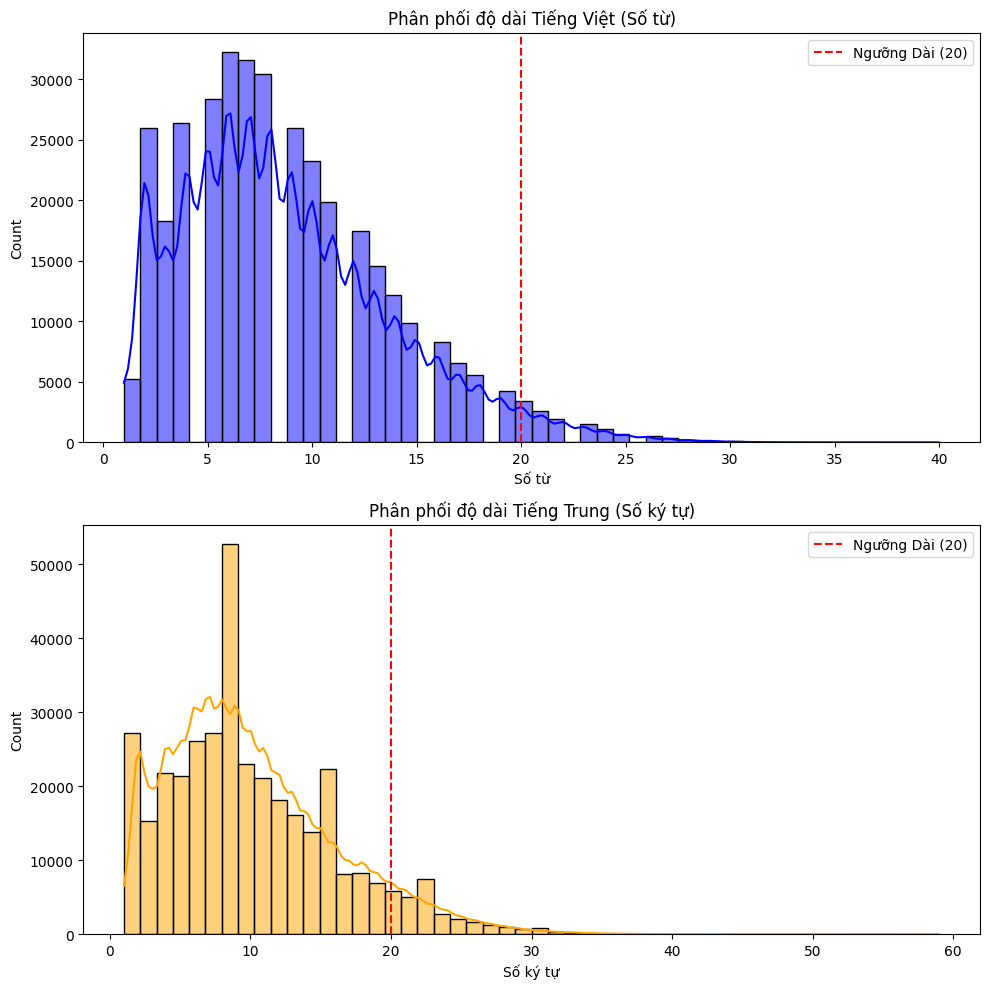


[THỐNG KÊ CHI TIẾT]
Số lượng câu dài (> 20) Tiếng Việt: 9346 / 358806
Số lượng câu dài (> 20) Tiếng Trung: 23390 / 358806


In [6]:
def visualize_bilingual_data(dataset):
    # Lấy mẫu tập train
    df_vis = pd.DataFrame(dataset['train'][:])

    print("\n" + "="*50)
    print("PHÂN TÍCH ĐỘ DÀI CÂU (SENTENCE LENGTH ANALYSIS)")
    print("="*50)

    # 1. Tính độ dài
    # Tiếng Việt: Đếm số từ (Words)
    df_vis['vi_len'] = df_vis['vi'].astype(str).apply(lambda x: len(x.split()))
    # Tiếng Trung: Đếm số ký tự (Characters)
    df_vis['zh_len'] = df_vis['zh'].astype(str).apply(len)

    # 2. Phân loại (giữ lại phần này cho mục đích thống kê text)
    LONG_THRESHOLD = 20

    def categorize(length):
        if length < 10: return 'Ngắn (<10)'
        elif length <= LONG_THRESHOLD: return f'Trung bình (10-{LONG_THRESHOLD})'
        else: return f'Dài (>{LONG_THRESHOLD})'

    df_vis['cat_vi'] = df_vis['vi_len'].apply(categorize)
    df_vis['cat_zh'] = df_vis['zh_len'].apply(categorize)

    # 3. Vẽ biểu đồ (Chỉ 1 cột histogram cho mỗi ngôn ngữ)
    # Sử dụng subplots với 2 hàng, 1 cột
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # --- Hàng 1: Tiếng Việt ---
    # Hist
    sns.histplot(df_vis['vi_len'], bins=50, kde=True, color='blue', ax=axes[0])
    axes[0].set_title('Phân phối độ dài Tiếng Việt (Số từ)')
    axes[0].axvline(x=LONG_THRESHOLD, color='r', linestyle='--', label=f'Ngưỡng Dài ({LONG_THRESHOLD})')
    axes[0].legend()
    axes[0].set_xlabel('Số từ')

    # --- Hàng 2: Tiếng Trung ---
    # Hist
    sns.histplot(df_vis['zh_len'], bins=50, kde=True, color='orange', ax=axes[1])
    axes[1].set_title('Phân phối độ dài Tiếng Trung (Số ký tự)')
    axes[1].axvline(x=LONG_THRESHOLD, color='r', linestyle='--', label=f'Ngưỡng Dài ({LONG_THRESHOLD})')
    axes[1].legend()
    axes[1].set_xlabel('Số ký tự')

    plt.tight_layout()
    plt.show()

    # In thống kê text
    print(f"\n[THỐNG KÊ CHI TIẾT]")
    print(f"Số lượng câu dài (> {LONG_THRESHOLD}) Tiếng Việt: {len(df_vis[df_vis['vi_len'] > LONG_THRESHOLD])} / {len(df_vis)}")
    print(f"Số lượng câu dài (> {LONG_THRESHOLD}) Tiếng Trung: {len(df_vis[df_vis['zh_len'] > LONG_THRESHOLD])} / {len(df_vis)}")

# Thay thế lệnh gọi hàm cũ bằng hàm mới:
visualize_bilingual_data(raw_datasets)

In [5]:
# ==============================================================================
# BƯỚC 6: TOKENIZATION & MODEL SETUP
# ==============================================================================
model_checkpoint = "Helsinki-NLP/opus-mt-zh-vi"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    model_inputs = tokenizer(examples["zh"], max_length=128, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["vi"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/750k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/766k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Map:   0%|          | 0/358806 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

Map:   0%|          | 0/76887 [00:00<?, ? examples/s]

Map:   0%|          | 0/76887 [00:00<?, ? examples/s]

In [9]:
# ==============================================================================
# Chỉ chạy khi muốn training lại mô hình
# ==============================================================================

# 1. Xác định thư mục chứa checkpoint
# (Code của bạn đang trỏ vào folder này)
output_dir_path = args.output_dir

# 2. Xóa toàn bộ thư mục output cũ để đảm bảo sạch sẽ 100%
if os.path.exists(output_dir_path):
    try:
        print(f"   -> Đang xóa thư mục cũ: {output_dir_path}")
        shutil.rmtree(output_dir_path) # Lệnh này xóa cực mạnh, xóa cả folder con
        print("   -> Đã xóa sạch thành công!")
    except Exception as e:
        print(f"   -> Không xóa được (Lỗi quyền hoặc Drive): {e}")
else:
    print("   -> Thư mục đã sạch, không cần xóa.")

# 3. Tạo lại thư mục rỗng
os.makedirs(output_dir_path, exist_ok=True)

   -> Đang xóa thư mục cũ: /content/drive/MyDrive/Colab_Notebooks/ITP/workspace/zh-vi-historical-model
   -> Đã xóa sạch thành công!


In [10]:
# ==============================================================================
# BƯỚC 7: TRAINING (ĐÃ SỬA LỖI TÊN THAM SỐ)
# ==============================================================================

def clean_checkpoint_for_resume(output_dir):
    checkpoints = glob.glob(os.path.join(output_dir, "checkpoint-*"))
    if not checkpoints: return None
    latest_ckpt = max(checkpoints, key=os.path.getctime)
    print(f"Đang kiểm tra checkpoint: {latest_ckpt}")
    garbage_files = ["scaler.pt", "rng_state.pth"]
    for gf in garbage_files:
        path = os.path.join(latest_ckpt, gf)
        if os.path.exists(path):
            try:
                os.remove(path)
                print(f"   -> Đã xóa file gây lỗi: {gf}")
            except: pass
    return latest_ckpt

# Cấu hình Train
args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",

    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.02,
    save_total_limit=2,
    num_train_epochs=5,
    predict_with_generate=True,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=USE_FP16, # Tự động bật tắt theo GPU
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"], # Đánh giá trên file Validation
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[early_stopping]
)

# Tự động tìm và sửa checkpoint trước khi train
resume_ckpt = clean_checkpoint_for_resume(OUTPUT_DIR)

print("\nBẮT ĐẦU HUẤN LUYỆN...")
trainer.train(resume_from_checkpoint=resume_ckpt)

/tmp/ipython-input-1786199239.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(



BẮT ĐẦU HUẤN LUYỆN...


Epoch,Training Loss,Validation Loss
1,1.231500,1.562232
2,1.159800,1.569744
3,1.171700,1.564073
4,1.159300,1.565574


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


TrainOutput(global_step=89704, training_loss=1.1549658243337007, metrics={'train_runtime': 7037.636, 'train_samples_per_second': 254.919, 'train_steps_per_second': 15.933, 'total_flos': 6461372105883648.0, 'train_loss': 1.1549658243337007, 'epoch': 4.0})

In [11]:
# ==============================================================================
# BƯỚC 8: LƯU & ĐÁNH GIÁ TRÊN TẬP TEST VÀ VALIDATION
# ==============================================================================
print("\nĐANG LƯU MODEL...")
trainer.save_model(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)

print("\nĐANG ĐÁNH GIÁ...")
bleu_metric = evaluate.load("sacrebleu")

def compute_metrics_final(model, dataset, name="Tập dữ liệu"):
    print(f"\n--- Đang tính BLEU cho {name} ---")
    # Lấy mẫu ngẫu nhiên 500 câu để test nhanh
    sample_ds = dataset.shuffle(seed=42).select(range(min(500, len(dataset))))

    preds = trainer.predict(sample_ds)
    decoded_preds = tokenizer.batch_decode(preds.predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(preds.label_ids, skip_special_tokens=True)

    seg_preds = [" ".join(word_tokenize(p, format="text").split()) for p in decoded_preds]
    seg_labels = [[" ".join(word_tokenize(l, format="text").split())] for l in decoded_labels]

    res = bleu_metric.compute(predictions=seg_preds, references=seg_labels)
    print(f"Result for {name}: {res['score']:.2f}")
    return res['score']

# Đánh giá trên cả 2 tập
score_val = compute_metrics_final(model, tokenized_datasets['validation'], name="VALIDATION SET")
score_test = compute_metrics_final(model, tokenized_datasets['test'], name="TEST SET")

print(f"\n>>> TỔNG KẾT:")
print(f"BLEU Validation: {score_val:.2f}")
print(f"BLEU Test:       {score_test:.2f}")


ĐANG LƯU MODEL...

ĐANG ĐÁNH GIÁ...

--- Đang tính BLEU cho VALIDATION SET ---


Result for VALIDATION SET: 37.50

--- Đang tính BLEU cho TEST SET ---


Result for TEST SET: 36.90

>>> TỔNG KẾT:
BLEU Validation: 37.50
BLEU Test:       36.90


In [12]:
# ==============================================================================
# BƯỚC 9: KIỂM TRA THỰC TẾ (DEMO & VISUALIZATION)
# ==============================================================================
from transformers import pipeline

print("\n" + "="*50)
print("DEMO KẾT QUẢ DỊCH THỰC TẾ")
print("="*50)

# 1. Khởi tạo Pipeline dịch thuật (Sử dụng model vừa train xong)
translator = pipeline(
    "translation",
    model=FINAL_MODEL_DIR,
    tokenizer=FINAL_MODEL_DIR,
    device=0 if torch.cuda.is_available() else -1 # Chạy trên GPU nếu có
)

# 2. Lấy ngẫu nhiên 10 mẫu từ tập Test (Dữ liệu gốc chưa tokenized)
# Lưu ý: Dùng raw_datasets để lấy chữ đọc được, không dùng tokenized_datasets
sample_indices = random.sample(range(len(raw_datasets['test'])), 10)
samples = raw_datasets['test'].select(sample_indices)

# 3. Thực hiện dịch và so sánh
results = []
print("Đang dịch thử các mẫu ngẫu nhiên...")

for item in tqdm(samples):
    src_text = item['zh']
    ref_text = item['vi']

    # Máy dịch
    pred_text = translator(src_text)[0]['translation_text']

    results.append({
        "Tiếng Trung (Input)": src_text,
        "Tiếng Việt (Người dịch)": ref_text,
        "Tiếng Việt (Mô hình dịch)": pred_text
    })

# 4. Hiển thị bảng kết quả
df_results = pd.DataFrame(results)

# Cấu hình pandas để hiển thị hết nội dung dài
pd.set_option('display.max_colwidth', None)

# Hiển thị bảng
from IPython.display import display, HTML
print("\n>>> BẢNG SO SÁNH KẾT QUẢ:")
display(df_results)

# 5. Lưu kết quả ra Excel/CSV để làm báo cáo
df_results.to_csv(os.path.join(MAIN_WORKSPACE, 'ket_qua_dich_thuc_te.csv'), index=False)
print(f"\nĐã lưu file kết quả mẫu tại: {os.path.join(MAIN_WORKSPACE, 'ket_qua_dich_thuc_te.csv')}")


DEMO KẾT QUẢ DỊCH THỰC TẾ


Device set to use cuda:0


Đang dịch thử các mẫu ngẫu nhiên...


  0%|          | 0/10 [00:00<?, ?it/s]


>>> BẢNG SO SÁNH KẾT QUẢ:


,Tiếng Trung (Input),Tiếng Việt (Người dịch),Tiếng Việt (Mô hình dịch)
0,看来他这阴影回忆还挺重的,Xem ra kí ức ám ảnh của hắn cũng nặng phết.,Xem ra kí ức bóng tối của hắn khá nặng đấy.
1,我们一块儿去 好 咱们一起 秦姨娘 你也去,"Chúng ta cùng đi. Được. Chúng ta cùng đi. Tần di nương, cô cũng đi.","Chúng ta cùng đi. Được, chúng ta cùng đi. Tần di nương, người cũng đi đi."
2,那平乐殿下那里,"Vậy phía Bình Nhạc điện hạ,",Vậy chỗ Bình Nhạc điện hạ
3,雷霆,lôi đình,Lôi đình.
4,假如 他是在等什么人 那航海图必定有标记,"Giả dụ là để đợi người chẳng hạn, thì trên tấm hải đồ chắc chắn phải có ký hiệu.","Nếu như hắn đang đợi ai đó, tấm hải đồ đó chắc chắn có ký hiệu."
5,现在又在谷底独处数日 孤男寡女,bây giờ lại ở riêng với nhau trong khe núi nhiều ngày. Cô nam quả nữ…,"Bây giờ lại ở một mình dưới đáy cốc nhiều ngày. Một nam một nữ mồ côi,"
6,我发誓 只要相柳帮我把轩身上的蛊解掉,"Ta xin thề. Chỉ cần Tương Liễu giúp ta giải được cổ trùng trên người Hiên,","Ta thề chỉ cần Tương Liễu giải cổ trùng trên người Hiên giúp ta,"
7,别再来烦我,Đừng đến phiền ta nữa.,đừng đến làm phiền ta nữa.
8,最好是,"Tốt nhất là như vậy,",Tốt nhất là
9,痛吾痛以及人之痛,"""Đau nỗi đau của ta và nỗi đau của người.""",đau đớn và nỗi đau của con người.



Đã lưu file kết quả mẫu tại: /content/drive/MyDrive/Colab_Notebooks/ITP/ket_qua_dich_thuc_te.csv


In [13]:
# ==============================================================================
# BƯỚC 10: THỬ NGHIỆM TỰ NHẬP CÂU (INTERACTIVE DEMO)
# ==============================================================================
print("\n" + "="*50)
print("THỬ NGHIỆM: BẠN NHẬP - MÁY DỊCH")
print("="*50)

def translate_sentence(sentence):
    pred = translator(sentence)[0]['translation_text']
    print(f"🇨🇳 Trung: {sentence}")
    print(f"🇻🇳 Việt : {pred}")
    print("-" * 30)

# Thử vài câu kinh điển
custom_sentences = [
    "皇上，臣妾真的不知道该怎么办了。", # Hoàng thượng, thần thiếp thật sự không biết phải làm sao.
    "大胆奴才，竟然敢欺骗朕！", # Tên nô tài to gan, dám lừa gạt Trẫm!
    "若有来生，我不愿再入帝王家。", # Nếu có kiếp sau, ta không muốn vào nhà đế vương nữa.
    "师兄，我们一起下山吧。", # Sư huynh, chúng ta cùng xuống núi đi.
    "陛下，若是您执意不念旧情，非要赐死萧将军，那么臣妾也绝不独活，愿随他一同赴黄泉。",
    "师兄，杀师之仇不共戴天，今日若不取这恶贼的狗命祭奠师父在天之灵，我有何颜面去见列祖列宗！",
    "启禀大将军，如今敌军兵临城下，城中粮草已尽，若三日之内没有援兵赶到，恐怕我们要全军覆没在这孤城之中了。",
    "哪怕全天下的人都背叛你，我也会在你身后背叛全世界，只要能护你一世周全，我便死而无憾。"
]

for s in custom_sentences:
    translate_sentence(s)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



THỬ NGHIỆM: BẠN NHẬP - MÁY DỊCH
🇨🇳 Trung: 皇上，臣妾真的不知道该怎么办了。
🇻🇳 Việt : Hoàng thượng, thần thiếp thật sự không biết phải làm gì nữa.
------------------------------
🇨🇳 Trung: 大胆奴才，竟然敢欺骗朕！
🇻🇳 Việt : Nô tài to gan, dám lừa trẫm.
------------------------------
🇨🇳 Trung: 若有来生，我不愿再入帝王家。
🇻🇳 Việt : Nếu có kiếp sau, ta không muốn vào Đế Vương gia nữa.
------------------------------
🇨🇳 Trung: 师兄，我们一起下山吧。
🇻🇳 Việt : Sư huynh, chúng ta cùng xuống núi đi.
------------------------------
🇨🇳 Trung: 陛下，若是您执意不念旧情，非要赐死萧将军，那么臣妾也绝不独活，愿随他一同赴黄泉。
🇻🇳 Việt : Bệ hạ, nếu người khăng khăng không nể tình xưa, vậy thần thiếp tuyệt đối sẽ không sống chết một mình, cùng người đến suối vàng.
------------------------------
🇨🇳 Trung: 师兄，杀师之仇不共戴天，今日若不取这恶贼的狗命祭奠师父在天之灵，我有何颜面去见列祖列宗！
🇻🇳 Việt : Sư huynh, mối thù giết sư phụ không đội trời chung. Nếu hôm nay không lấy con chó của tên ác tặc này tế linh sư phụ,
------------------------------
🇨🇳 Trung: 启禀大将军，如今敌军兵临城下，城中粮草已尽，若三日之内没有援兵赶到，恐怕我们要全军覆没在这孤城之中了。
🇻🇳 Việt : Khởi bẩm đại tướng q